# Preliminary work

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

Data import

In [ ]:
df = pd.read_csv("output_data.csv") #FILL THE PATH WITH THE PROPER OUTPUT DATA

df["Datetime"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["Datetime"]) 

df = df.sort_values("Datetime")

df["hourly"] = df["Datetime"].dt.floor("h")
df["daily"] = df["Datetime"].dt.floor("d")

days_df = df.groupby("daily").agg({
    "power_active_import": "mean",
    "temperature": "mean"
}).reset_index()

days_df = days_df.rename(columns={
    "daily": "Datetime",
    "power_active_import": "power_active_import_avg_current_day",
    "temperature": "Temperature_avg_current_day"
})

hours_df = df.groupby("hourly").agg({
    "power_active_import": "mean",
    "temperature": "mean"
}).reset_index()

hours_df = hours_df.rename(columns={
    "hourly": "Datetime",
    "power_active_import": "power_active_import_avg_current_hour",
    "temperature": "Temperature_avg_current_hour"
})

# Next five days active power import predictions

## Data processing

Parameters

In [3]:
number_of_predict_days = 1

Set the dataframe to train te model

In [4]:
for i in range(1, number_of_predict_days+1):
    days_df[f"power_active_import_avg_{i}d_future"] = days_df["power_active_import_avg_current_day"].shift(-i)
    days_df[f"temperature_avg_{i}d_future"] = days_df["Temperature_avg_current_day"].shift(-i)

days_df.dropna(inplace=True)

Correlation heatmap

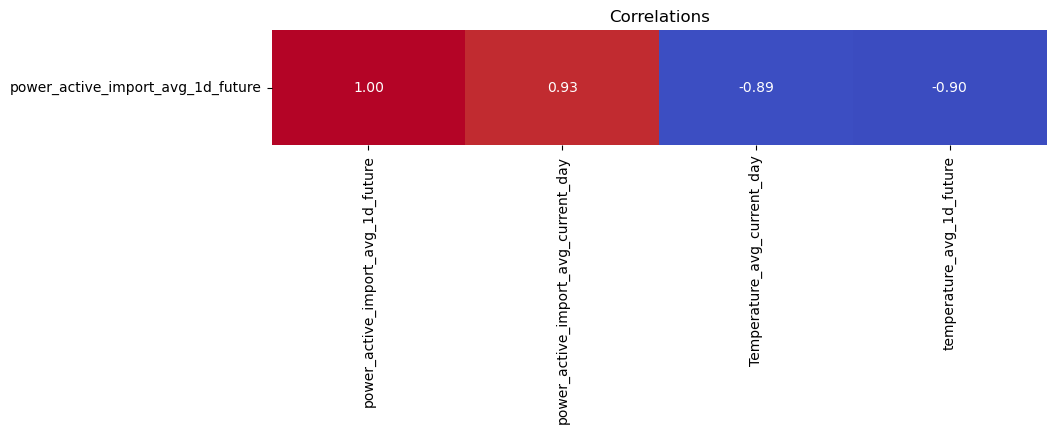

In [5]:
target_vars = [f"power_active_import_avg_{i}d_future" for i in range(1, number_of_predict_days+1)]
X_days = days_df.copy().drop(columns=(target_vars + ["Datetime"]))
Y_days = days_df.copy()[target_vars]

data = pd.concat([Y_days, X_days], axis=1, join="inner")

# Correlation analysis between future import targets and input features
corr = data.corr()

corr_row = corr.loc[target_vars]

# Heatmap
plt.figure(figsize=(10, 1.5))
sns.heatmap(corr_row, annot=True, cmap="coolwarm", fmt=".2f", cbar=False)
plt.title(f"Correlations")
plt.yticks(rotation=0)
plt.show()

## Training the model

In [6]:
X_train_days, X_test_days, Y_train_days, Y_test_days = train_test_split(
    X_days, Y_days, test_size=0.2, random_state=42
)

base_model = RandomForestRegressor(n_estimators=200, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train_days, Y_train_days)

MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=200,
                                                     random_state=42))

Model saving

In [7]:
from joblib import dump

dump(model, "days_prediction.joblib")

['days_prediction.joblib']

## Results

In [8]:
Y_pred_days = model.predict(X_test_days)

mae = mean_absolute_error(Y_test_days, Y_pred_days)
r2 = r2_score(Y_test_days, Y_pred_days)

print(f"MAE : {mae:.2f} W")
print(f"R²  : {r2:.3f}")

MAE : 322.11 W
R²  : 0.853


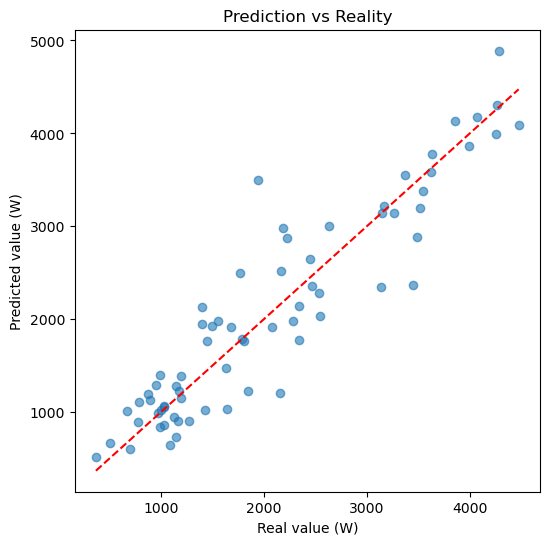

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(Y_test_days, Y_pred_days, alpha=0.6)
plt.xlabel("Real value (W)")
plt.ylabel("Predicted value (W)")
plt.title("Prediction vs Reality")
plt.plot([Y_test_days.min(), Y_test_days.max()], [Y_test_days.min(), Y_test_days.max()], "r--")
plt.show()

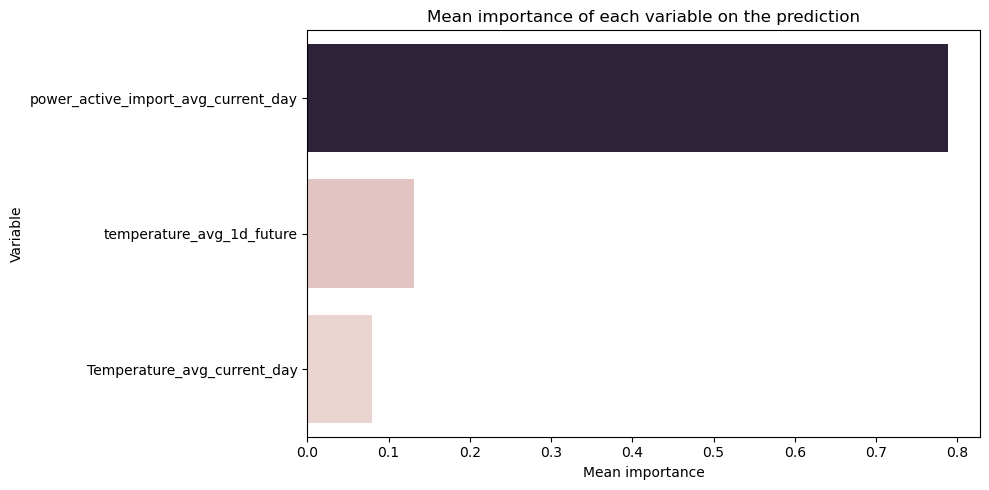

In [10]:
# Collect feature importances from each estimator of the multi-output model
all_importances = np.array([
    est.feature_importances_ for est in model.estimators_
])

# Average feature importance across all predicted horizons (24 hours)
mean_importances = all_importances.mean(axis=0)

# Rank features by their average contribution to the prediction
importances = pd.Series(mean_importances, index=X_days.columns).sort_values(ascending=False)

#Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index, hue=importances.values, legend=False)
plt.title("Mean importance of each variable on the prediction")
plt.xlabel("Mean importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Next 24 hours active power import predictions

## Data processing

Parameters

In [11]:
number_of_predict_hours = 24

Set the dataframe to train te model

In [12]:
for i in range(1, number_of_predict_hours+1):
    hours_df[f"power_active_import_avg_{i}h_future"] = hours_df["power_active_import_avg_current_hour"].shift(-i)
    hours_df[f"temperature_avg_{i}h_future"] = hours_df["Temperature_avg_current_hour"].shift(-i)

In [13]:
X_days_full = days_df.drop(columns=target_vars)
Y_days_pred = model.predict(X_days)

next_day_pred = Y_days_pred[:, 0]

days_df_pred = days_df[["Datetime"]].copy()
days_df_pred["power_active_import_avg_1d_future_pred"] = next_day_pred

In [14]:
days_df_pred.head(1)

,Datetime,power_active_import_avg_1d_future_pred
0,2024-07-01,849.63054


In [15]:
# Extract the date (without the time) for merging with the second DataFrame
hours_df["Date"] = hours_df["Datetime"].dt.date
days_df_pred["Date"] = days_df_pred["Datetime"].dt.date

# Merge the two DataFrames on the "Date" column
hours_df = hours_df.merge(
    days_df_pred[["Date", "power_active_import_avg_1d_future_pred"]],
    on="Date",
    how="left"
)

# Drop the temporary "Date" column after the merge
hours_df = hours_df.drop(columns=["Date"])
hours_df.dropna(inplace=True)

In [16]:
hours_df.head(1)

,Datetime,power_active_import_avg_current_hour,Temperature_avg_current_hour,power_active_import_avg_1h_future,temperature_avg_1h_future,power_active_import_avg_2h_future,temperature_avg_2h_future,power_active_import_avg_3h_future,temperature_avg_3h_future,power_active_import_avg_4h_future,...,temperature_avg_20h_future,power_active_import_avg_21h_future,temperature_avg_21h_future,power_active_import_avg_22h_future,temperature_avg_22h_future,power_active_import_avg_23h_future,temperature_avg_23h_future,power_active_import_avg_24h_future,temperature_avg_24h_future,power_active_import_avg_1d_future_pred
0,2024-07-01,809.129167,15.366667,716.583333,14.27625,578.2625,13.339583,584.675,12.620833,538.883333,...,19.736667,854.4125,18.800417,1039.791667,17.709583,946.629167,16.53875,744.745833,15.554583,849.63054


Correlation heatmap

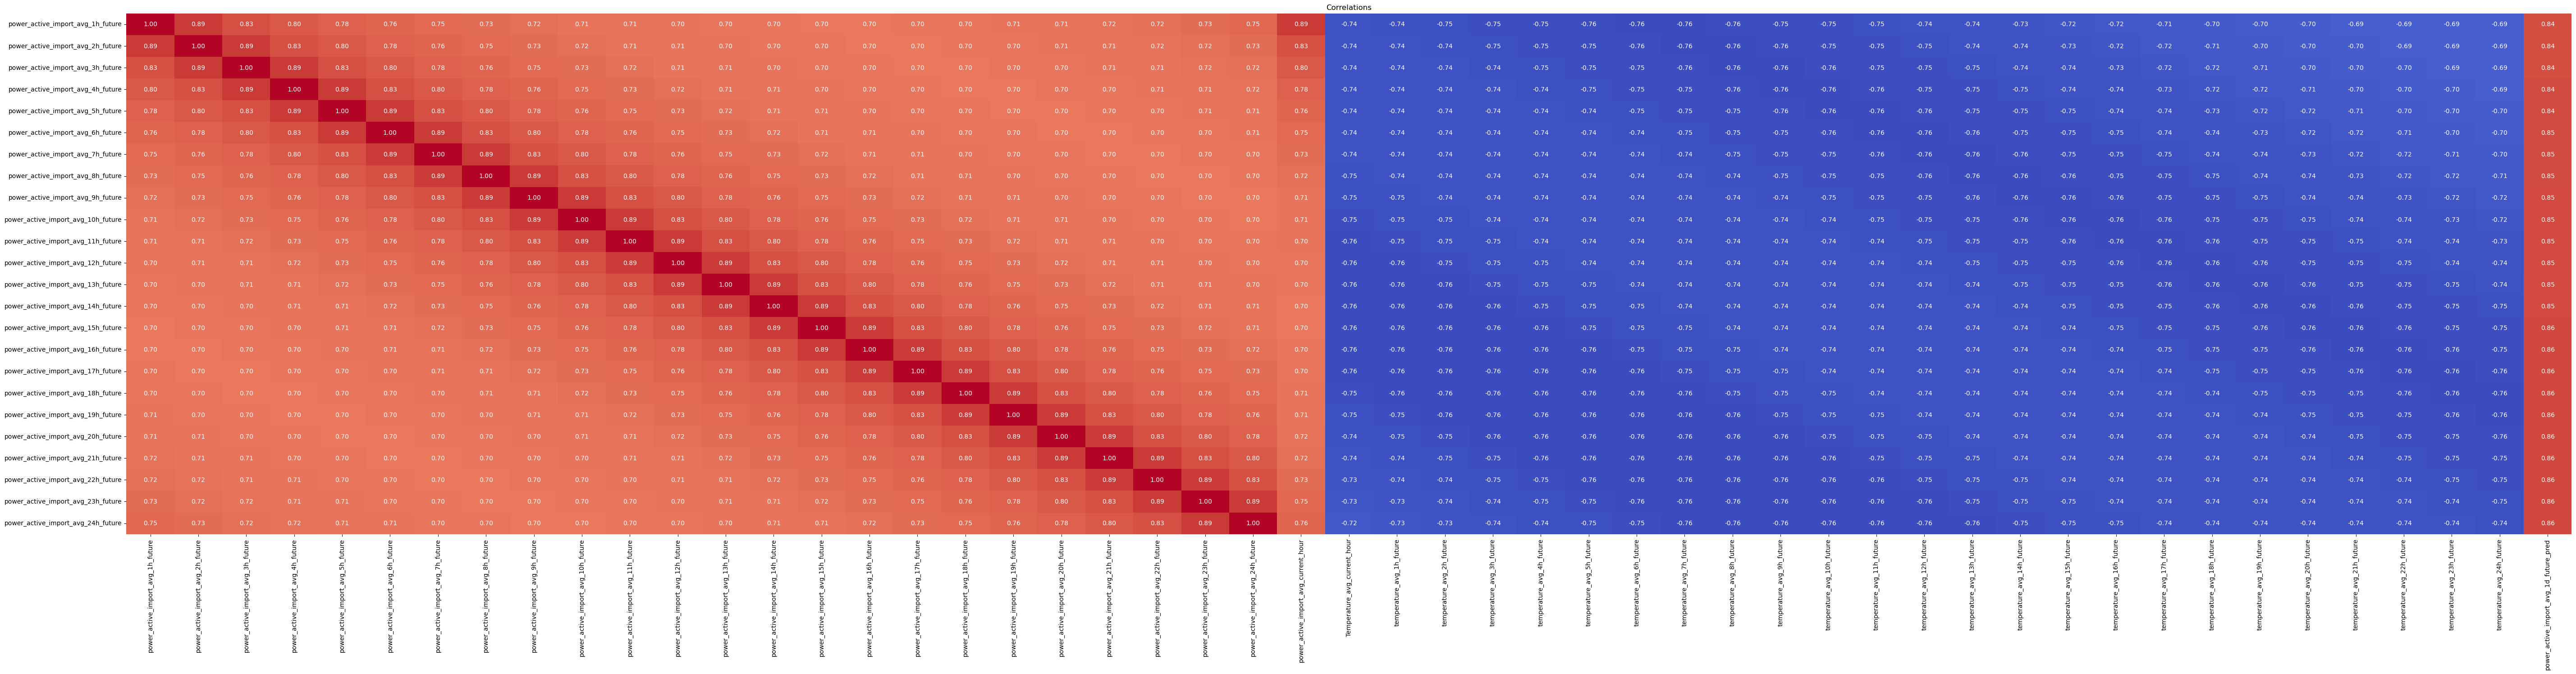

In [17]:
target_vars = [f"power_active_import_avg_{i}h_future" for i in range(1, number_of_predict_hours+1)]
X_hours = hours_df.copy().drop(columns=(target_vars + ["Datetime"]))
Y_hours = hours_df.copy()[target_vars]

data = pd.concat([Y_hours, X_hours], axis=1, join="inner")

corr = data.corr()

corr_row = corr.loc[target_vars]

plt.figure(figsize=(70, 15))
sns.heatmap(corr_row, annot=True, cmap="coolwarm", fmt=".2f", cbar=False)
plt.title(f"Correlations")
plt.yticks(rotation=0)
plt.show()

## Training the model

In [18]:
X_train_hours, X_test_hours, Y_train_hours, Y_test_hours = train_test_split(
    X_hours, Y_hours, test_size=0.2, random_state=42
)

base_model = RandomForestRegressor(n_estimators=200, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train_hours, Y_train_hours)

MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=200,
                                                     random_state=42))

Saving the model

In [19]:
dump(model, "hours_prediction.joblib")

['hours_prediction.joblib']

## Results

In [20]:
Y_pred_hours = model.predict(X_test_hours)

mae = mean_absolute_error(Y_test_hours, Y_pred_hours)
r2 = r2_score(Y_test_hours, Y_pred_hours)

print(f"MAE : {mae:.2f} W")
print(f"R²  : {r2:.3f}")

MAE : 412.25 W
R²  : 0.827


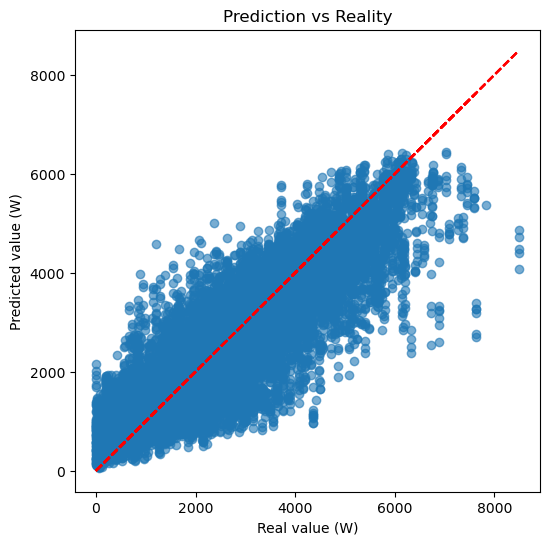

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(Y_test_hours, Y_pred_hours, alpha=0.6)
plt.xlabel("Real value (W)")
plt.ylabel("Predicted value (W)")
plt.title("Prediction vs Reality")
plt.plot([Y_test_hours.min(), Y_test_hours.max()], [Y_test_hours.min(), Y_test_hours.max()], "r--")
plt.show()

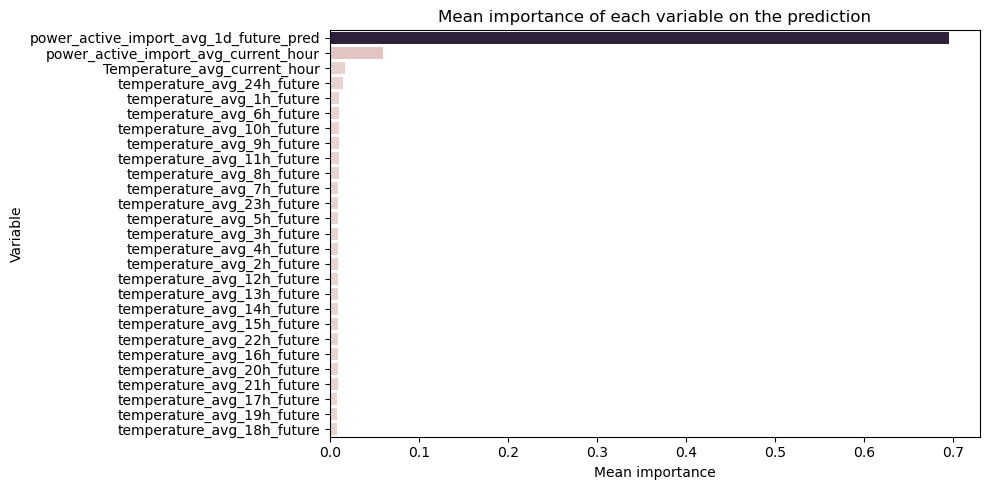

In [22]:
all_importances = np.array([
    est.feature_importances_ for est in model.estimators_
])

mean_importances = all_importances.mean(axis=0)

importances = pd.Series(mean_importances, index=X_hours.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index, hue=importances.values, legend=False)
plt.title("Mean importance of each variable on the prediction")
plt.xlabel("Mean importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()
